# Check out QSOIL (and other ET components) in CAM6+CLM5 simulation vs. CAM6+CLM4.5 simulation 
Does this match patterns we're seeing in changes in strength of the coupling index? 

In [1]:
## Import libraries 
import comet as cm 
import numpy as np 
import xarray as xr 
import pickle
import pandas as pd
import datetime 

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

## Read in files containing ET variables

In [9]:
# Define path and filenames 
dataDir = '/glade/work/mdfowler/data/HighOutput_IslasSims/'
# f.e21.FHIST.f09_f09.cesm2_cam6_clm4p5.001.clm2.h1.1990-1999_ETvars.nc
# f.e21.FHIST.f09_f09.cesm2_cam6_clm5.001.clm2.h1.1979-1989_ETvars.nc

fileStart_CLM5 = dataDir+'f.e21.FHIST.f09_f09.cesm2_cam6_clm5.001.clm2.h1.'
fileStart_CLM45 = dataDir+'f.e21.FHIST.f09_f09.cesm2_cam6_clm4p5.001.clm2.h1.'
fileEnd   = '_ETvars.nc'

decades   = ['1979-1989', '1990-1999', '2000-2014']

for iDec in range(len(decades)):
    with xr.open_dataset(fileStart_CLM5+decades[iDec]+fileEnd, decode_times=True) as DFclm5: 
        DFclm5['time'] = DFclm5.indexes['time'].to_datetimeindex()
        
        if iDec==0:
            clm5_ETdf = DFclm5
        else: 
            clm5_ETdf = xr.concat([clm5_ETdf,  DFclm5], dim="time")
        
    with xr.open_dataset(fileStart_CLM45+decades[iDec]+fileEnd, decode_times=True) as DFclm45: 
        DFclm45['time'] = DFclm45.indexes['time'].to_datetimeindex()
            
        if iDec==0:
            clm45_ETdf = DFclm45
        else: 
            clm45_ETdf = xr.concat([clm45_ETdf,  DFclm45], dim="time")

    print('Done with decade files: ', decades[iDec])
    

/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  
/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.


Done with decade files:  1979-1989
Done with decade files:  1990-1999
Done with decade files:  2000-2014


In [10]:
# Save lat and lon, along with dates into single arrays
lat = clm5_ETdf.lat.values
lon = clm5_ETdf.lon.values

# To be able to easily access years, months, days - use Pandas 
dates    = pd.DatetimeIndex(clm5_ETdf['time'].values)


In [11]:
# Get seasonal indices and limit years to 1980-2005 (period used for CI)
iJJA    = np.where((dates.month>=6) & (dates.month<=8) &
                   (dates.year>=1980) & (dates.year<=2005))[0]

iDJF    = np.where((dates.month==12) | (dates.month<=2) &
                   (dates.year>=1980) & (dates.year<=2005))[0]

iMAM    = np.where((dates.month>=3) & (dates.month<=5) &
                   (dates.year>=1980) & (dates.year<=2005))[0]

iSON    = np.where((dates.month>=9) & (dates.month<=11) &
                   (dates.year>=1980) & (dates.year<=2005))[0]


In [14]:
# Isolate seasons in arrays 
clm5_ETdf_JJA = clm5_ETdf.isel(time=iJJA)
clm5_ETdf_DJF = clm5_ETdf.isel(time=iDJF)

clm45_ETdf_JJA = clm45_ETdf.isel(time=iJJA)
clm45_ETdf_DJF = clm45_ETdf.isel(time=iDJF)


In [15]:
# Take time means 
clm5_ETdf_JJAmean = clm5_ETdf_JJA.mean(dim='time')
clm5_ETdf_DJFmean = clm5_ETdf_DJF.mean(dim='time')

clm45_ETdf_JJAmean = clm45_ETdf_JJA.mean(dim='time')
clm45_ETdf_DJFmean = clm45_ETdf_DJF.mean(dim='time')


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Plot maps of: 
* Raw evaporation terms in both simulations
* Change in evaporation terms (CLM5 - CLM4.5) 

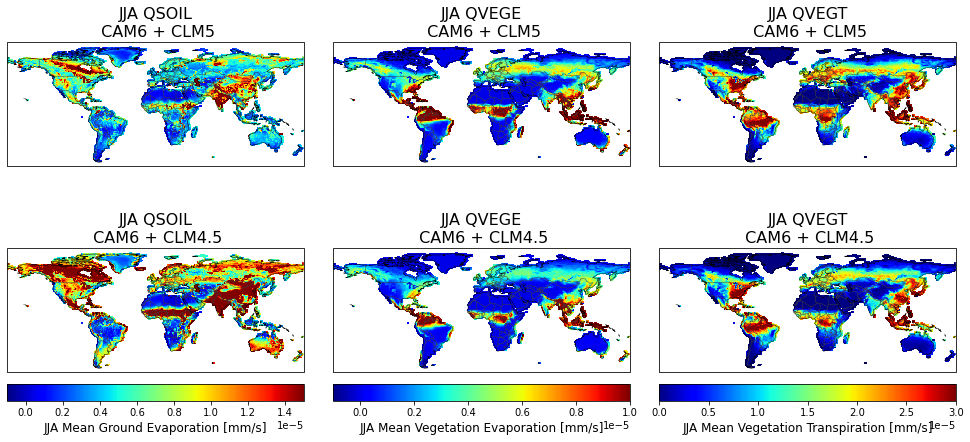

In [39]:
# ------------------------------------------- 
#   Plot evaporation terms for JJA 
# -------------------------------------------

# Set up figure 
fig, axs = plt.subplots(2,3, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# --- Plot QSOIL --- 
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,clm5_ETdf_JJAmean.QSOIL.values,
                             cmap='jet',
                             vmin=-1e-6,vmax=1.5e-5)

contour_plot = axs[3].pcolormesh(lon,lat,clm45_ETdf_JJAmean.QSOIL.values,
                             cmap='jet',
                             vmin=-1e-6,vmax=1.5e-5)
# Add colorbar 
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA Mean Ground Evaporation [mm/s]',fontsize=12)

# Additional options 
axs[0].set_title('JJA QSOIL\n CAM6 + CLM5',fontsize=16)
axs[3].set_title('JJA QSOIL\n CAM6 + CLM4.5',fontsize=16)
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# --- Plot QVEGE --- 
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[1].pcolormesh(lon,lat,clm5_ETdf_JJAmean.QVEGE.values,
                             cmap='jet',
                             vmin=-1e-6,vmax=1e-5)

contour_plot = axs[4].pcolormesh(lon,lat,clm45_ETdf_JJAmean.QVEGE.values,
                             cmap='jet',
                             vmin=-1e-6,vmax=1e-5)
# Add colorbar 
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA Mean Vegetation Evaporation [mm/s]',fontsize=12)

# Additional options 
axs[1].set_title('JJA QVEGE\n CAM6 + CLM5',fontsize=16)
axs[4].set_title('JJA QVEGE\n CAM6 + CLM4.5',fontsize=16)
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# --- Plot QVEGT --- 
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[2].pcolormesh(lon,lat,clm5_ETdf_JJAmean.QVEGT.values,
                             cmap='jet',
                             vmin=0,vmax=3e-5)

contour_plot = axs[5].pcolormesh(lon,lat,clm45_ETdf_JJAmean.QVEGT.values,
                             cmap='jet',
                             vmin=-0,vmax=3e-5)
# Add colorbar 
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA Mean Vegetation Transpiration [mm/s]',fontsize=12)

# Additional options 
axs[2].set_title('JJA QVEGT\n CAM6 + CLM5',fontsize=16)
axs[5].set_title('JJA QVEGT\n CAM6 + CLM4.5',fontsize=16)
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



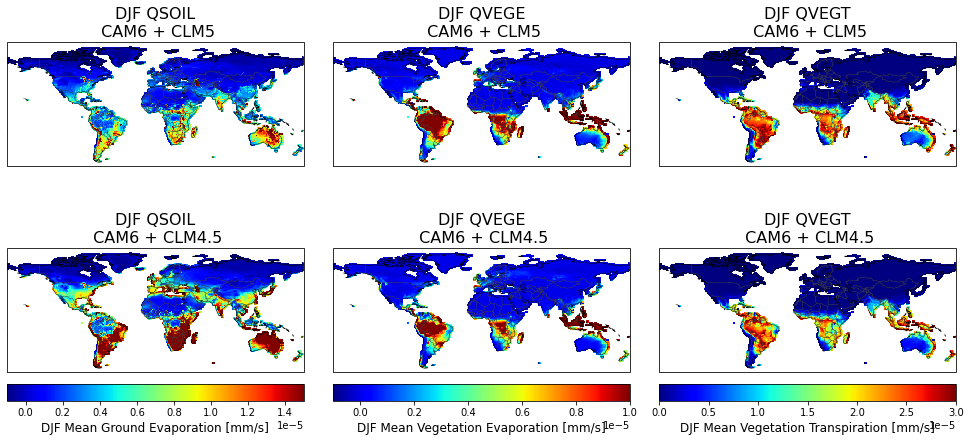

In [40]:
# ------------------------------------------- 
#   Plot evaporation terms for DJF 
# -------------------------------------------

# Set up figure 
fig, axs = plt.subplots(2,3, figsize=(17, 8), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# --- Plot QSOIL --- 
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[3].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,clm5_ETdf_DJFmean.QSOIL.values,
                             cmap='jet',
                             vmin=-1e-6,vmax=1.5e-5)

contour_plot = axs[3].pcolormesh(lon,lat,clm45_ETdf_DJFmean.QSOIL.values,
                             cmap='jet',
                             vmin=-1e-6,vmax=1.5e-5)
# Add colorbar 
ax_position = axs[3].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('DJF Mean Ground Evaporation [mm/s]',fontsize=12)

# Additional options 
axs[0].set_title('DJF QSOIL\n CAM6 + CLM5',fontsize=16)
axs[3].set_title('DJF QSOIL\n CAM6 + CLM4.5',fontsize=16)
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[3].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[3].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# --- Plot QVEGE --- 
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[4].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[1].pcolormesh(lon,lat,clm5_ETdf_DJFmean.QVEGE.values,
                             cmap='jet',
                             vmin=-1e-6,vmax=1e-5)

contour_plot = axs[4].pcolormesh(lon,lat,clm45_ETdf_DJFmean.QVEGE.values,
                             cmap='jet',
                             vmin=-1e-6,vmax=1e-5)
# Add colorbar 
ax_position = axs[4].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('DJF Mean Vegetation Evaporation [mm/s]',fontsize=12)

# Additional options 
axs[1].set_title('DJF QVEGE\n CAM6 + CLM5',fontsize=16)
axs[4].set_title('DJF QVEGE\n CAM6 + CLM4.5',fontsize=16)
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[4].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[4].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# --- Plot QVEGT --- 
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      
axs[5].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree()) 

# Contour plots 
contour_plot = axs[2].pcolormesh(lon,lat,clm5_ETdf_DJFmean.QVEGT.values,
                             cmap='jet',
                             vmin=0,vmax=3e-5)

contour_plot = axs[5].pcolormesh(lon,lat,clm45_ETdf_DJFmean.QVEGT.values,
                             cmap='jet',
                             vmin=-0,vmax=3e-5)
# Add colorbar 
ax_position = axs[5].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('DJF Mean Vegetation Transpiration [mm/s]',fontsize=12)

# Additional options 
axs[2].set_title('DJF QVEGT\n CAM6 + CLM5',fontsize=16)
axs[5].set_title('DJF QVEGT\n CAM6 + CLM4.5',fontsize=16)
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[5].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')
axs[5].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




**Now let's look at the differences...**

In [41]:
diffJJA = clm5_ETdf_JJA - clm45_ETdf_JJA
diffDJF = clm5_ETdf_DJF - clm45_ETdf_DJF

In [56]:
# Also get the mean over time again
diffJJAmean = diffJJA.mean(dim='time')
diffDJFmean = diffDJF.mean(dim='time')


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


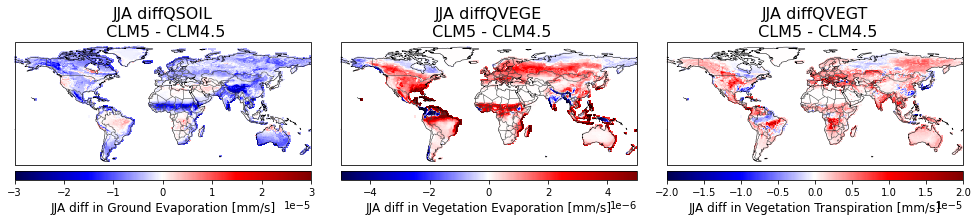

In [65]:
# ------------------------------------------- 
#   Plot evaporation term differences for JJA  
# -------------------------------------------

# Set up figure 
fig, axs = plt.subplots(1,3, figsize=(17, 4), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# --- Plot QSOIL difference --- 
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,diffJJAmean.QSOIL.values,
                             cmap='seismic',
                             vmin=-3e-5,vmax=3e-5)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA diff in Ground Evaporation [mm/s]',fontsize=12)

# Additional options 
axs[0].set_title('JJA diffQSOIL\n CLM5 - CLM4.5',fontsize=16)
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# --- Plot QVEGE --- 
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = axs[1].pcolormesh(lon,lat,diffJJAmean.QVEGE.values,
                             cmap='seismic',
                             vmin=-0.5e-5,vmax=0.5e-5)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA diff in Vegetation Evaporation [mm/s]',fontsize=12)

# Additional options 
axs[1].set_title('JJA diffQVEGE\n CLM5 - CLM4.5',fontsize=16)
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# --- Plot QVEGT --- 
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = axs[2].pcolormesh(lon,lat,diffJJAmean.QVEGT.values,
                             cmap='seismic',
                             vmin=-2e-5,vmax=2e-5)

# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('JJA diff in Vegetation Transpiration [mm/s]',fontsize=12)

# Additional options 
axs[2].set_title('JJA diffQVEGT\n CLM5 - CLM4.5',fontsize=16)
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



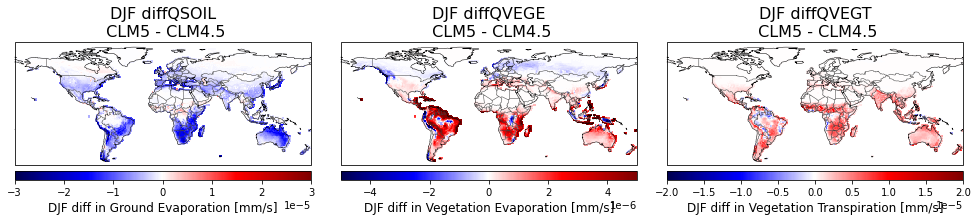

In [66]:
# ------------------------------------------- 
#   Plot evaporation term differences for DJF  
# -------------------------------------------

# Set up figure 
fig, axs = plt.subplots(1,3, figsize=(17, 4), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = -0.1,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# --- Plot QSOIL difference --- 
axs[0].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = axs[0].pcolormesh(lon,lat,diffDJFmean.QSOIL.values,
                             cmap='seismic',
                             vmin=-3e-5,vmax=3e-5)
# Add colorbar 
ax_position = axs[0].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('DJF diff in Ground Evaporation [mm/s]',fontsize=12)

# Additional options 
axs[0].set_title('DJF diffQSOIL\n CLM5 - CLM4.5',fontsize=16)
axs[0].coastlines(linewidth=0.5,edgecolor='0.25')
axs[0].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')


# --- Plot QVEGE --- 
axs[1].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = axs[1].pcolormesh(lon,lat,diffDJFmean.QVEGE.values,
                             cmap='seismic',
                             vmin=-0.5e-5,vmax=0.5e-5)
# Add colorbar 
ax_position = axs[1].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('DJF diff in Vegetation Evaporation [mm/s]',fontsize=12)

# Additional options 
axs[1].set_title('DJF diffQVEGE\n CLM5 - CLM4.5',fontsize=16)
axs[1].coastlines(linewidth=0.5,edgecolor='0.25')
axs[1].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')



# --- Plot QVEGT --- 
axs[2].set_extent([-180,180,-60,90], crs=ccrs.PlateCarree())      

# Contour plots 
contour_plot = axs[2].pcolormesh(lon,lat,diffDJFmean.QVEGT.values,
                             cmap='seismic',
                             vmin=-2e-5,vmax=2e-5)

# Add colorbar 
ax_position = axs[2].get_position()
cbar_ax = fig.add_axes([ax_position.x0, ax_position.y0-0.05, ax_position.width, 0.03])
cbar = plt.colorbar(contour_plot, orientation='horizontal',cax=cbar_ax)
cbar.set_label('DJF diff in Vegetation Transpiration [mm/s]',fontsize=12)

# Additional options 
axs[2].set_title('DJF diffQVEGT\n CLM5 - CLM4.5',fontsize=16)
axs[2].coastlines(linewidth=0.5,edgecolor='0.25')
axs[2].add_feature(cfeature.BORDERS,linewidth=0.5,edgecolor='0.25')




## Plot zonal means 

In [67]:
# First, want to apply ice mask so that we're not considering Greenland in all this 

# Read in single history file to get lat/lon and masks 
testName = '/glade/scratch/islas/archive/f.e21.FHIST.f09_f09.cesm2_cam6_clm5.001/lnd/hist/f.e21.FHIST.f09_f09.cesm2_cam6_clm5.001.clm2.h0.1989-12.nc'
testDF   = xr.open_dataset(testName)

# Ideally, want to mask out Greenland/Antarctica too (ice sheets)
iceContent = testDF.ICE_CONTENT1.values[0,:,:]  # "Initial gridcell total ice content"
iceMask    = np.full([len(lat),len(lon)], np.nan)
iceMask[iceContent<10000] = 1


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in less
  # Remove the CWD from sys.path while we load stuff.


In [80]:
# Take means over longitude
clm5_ETdf_JJAzonal = (clm5_ETdf_JJAmean*iceMask).mean(dim='lon')
clm5_ETdf_DJFzonal = (clm5_ETdf_DJFmean*iceMask).mean(dim='lon')

clm45_ETdf_JJAzonal = (clm45_ETdf_JJAmean*iceMask).mean(dim='lon')
clm45_ETdf_DJFzonal = (clm45_ETdf_DJFmean*iceMask).mean(dim='lon')


/glade/work/mdfowler/my_npl_clone/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


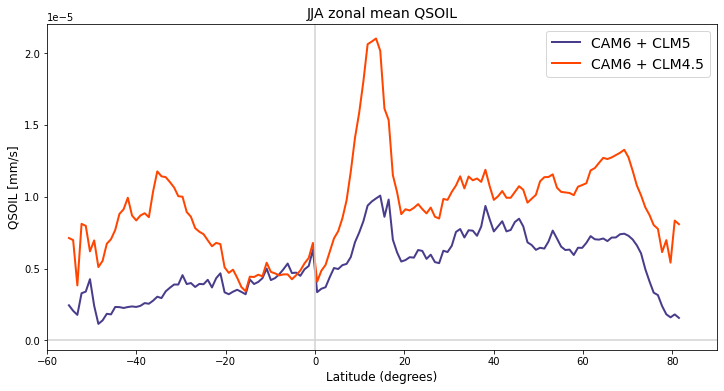

In [76]:
# ------------------------------
#  Plot zonal mean QSOIL [JJA]
# ------------------------------

# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(12, 6))

ax1.plot(lat,clm5_ETdf_JJAzonal.QSOIL.values,'darkslateblue', linewidth=2)
ax1.plot(lat,clm45_ETdf_JJAzonal.QSOIL.values,'orangered', linewidth=2)

ax1.legend(['CAM6 + CLM5','CAM6 + CLM4.5'], fontsize=14)
ax1.set_xlabel('Latitude (degrees)',fontsize=12)
ax1.set_ylabel('QSOIL [mm/s]',fontsize=12)
ax1.set_title('JJA zonal mean QSOIL', fontsize=14)
ax1.set_xlim([-60, 90])
ax1.axhline(0,color='lightgrey')
ax1.axvline(0,color='lightgrey')


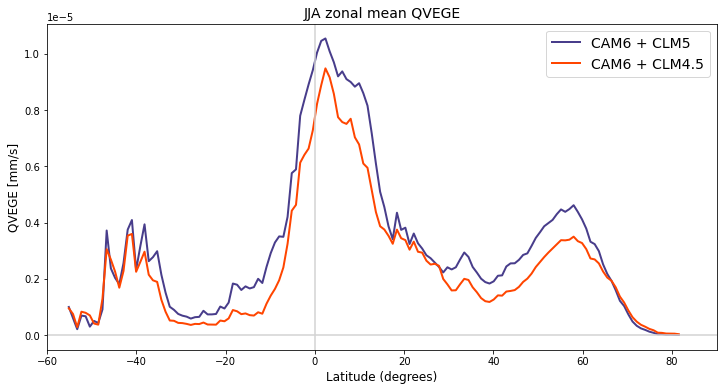

In [77]:
# ------------------------------
#  Plot zonal mean QVEGE [JJA]
# ------------------------------

# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(12, 6))

ax1.plot(lat,clm5_ETdf_JJAzonal.QVEGE.values,'darkslateblue', linewidth=2)
ax1.plot(lat,clm45_ETdf_JJAzonal.QVEGE.values,'orangered', linewidth=2)

ax1.legend(['CAM6 + CLM5','CAM6 + CLM4.5'], fontsize=14)
ax1.set_xlabel('Latitude (degrees)',fontsize=12)
ax1.set_ylabel('QVEGE [mm/s]',fontsize=12)
ax1.set_title('JJA zonal mean QVEGE', fontsize=14)
ax1.set_xlim([-60, 90])
ax1.axhline(0,color='lightgrey')
ax1.axvline(0,color='lightgrey')



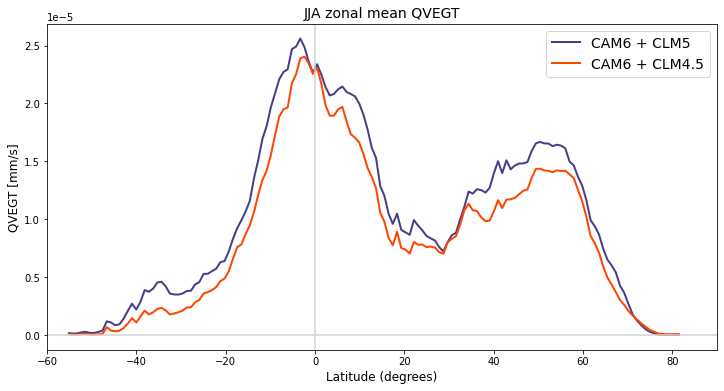

In [78]:
# ------------------------------
#  Plot zonal mean QVEGT [JJA]
# ------------------------------

# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(12, 6))

ax1.plot(lat,clm5_ETdf_JJAzonal.QVEGT.values,'darkslateblue', linewidth=2)
ax1.plot(lat,clm45_ETdf_JJAzonal.QVEGT.values,'orangered', linewidth=2)

ax1.legend(['CAM6 + CLM5','CAM6 + CLM4.5'], fontsize=14)
ax1.set_xlabel('Latitude (degrees)',fontsize=12)
ax1.set_ylabel('QVEGT [mm/s]',fontsize=12)
ax1.set_title('JJA zonal mean QVEGT', fontsize=14)
ax1.set_xlim([-60, 90])
ax1.axhline(0,color='lightgrey')
ax1.axvline(0,color='lightgrey')




**Also check DJF zonal means**

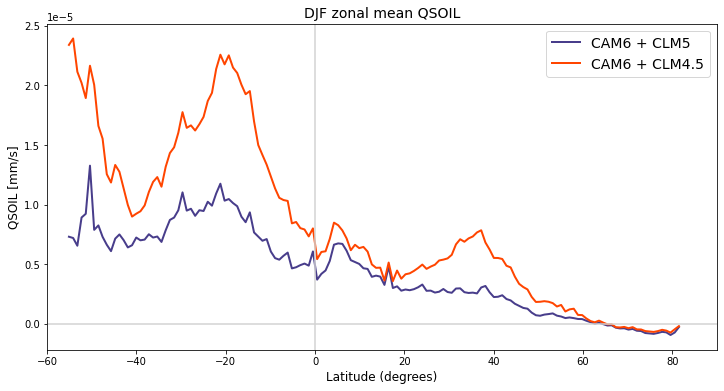

In [81]:
# ------------------------------
#  Plot zonal mean QSOIL [DJF]
# ------------------------------

# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(12, 6))

ax1.plot(lat,clm5_ETdf_DJFzonal.QSOIL.values,'darkslateblue', linewidth=2)
ax1.plot(lat,clm45_ETdf_DJFzonal.QSOIL.values,'orangered', linewidth=2)

ax1.legend(['CAM6 + CLM5','CAM6 + CLM4.5'], fontsize=14)
ax1.set_xlabel('Latitude (degrees)',fontsize=12)
ax1.set_ylabel('QSOIL [mm/s]',fontsize=12)
ax1.set_title('DJF zonal mean QSOIL', fontsize=14)
ax1.set_xlim([-60, 90])
ax1.axhline(0,color='lightgrey')
ax1.axvline(0,color='lightgrey')



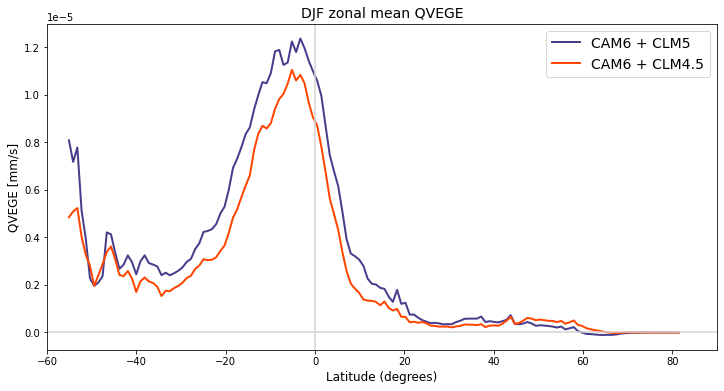

In [82]:
# ------------------------------
#  Plot zonal mean QVEGE [DJF]
# ------------------------------

# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(12, 6))

ax1.plot(lat,clm5_ETdf_DJFzonal.QVEGE.values,'darkslateblue', linewidth=2)
ax1.plot(lat,clm45_ETdf_DJFzonal.QVEGE.values,'orangered', linewidth=2)

ax1.legend(['CAM6 + CLM5','CAM6 + CLM4.5'], fontsize=14)
ax1.set_xlabel('Latitude (degrees)',fontsize=12)
ax1.set_ylabel('QVEGE [mm/s]',fontsize=12)
ax1.set_title('DJF zonal mean QVEGE', fontsize=14)
ax1.set_xlim([-60, 90])
ax1.axhline(0,color='lightgrey')
ax1.axvline(0,color='lightgrey')




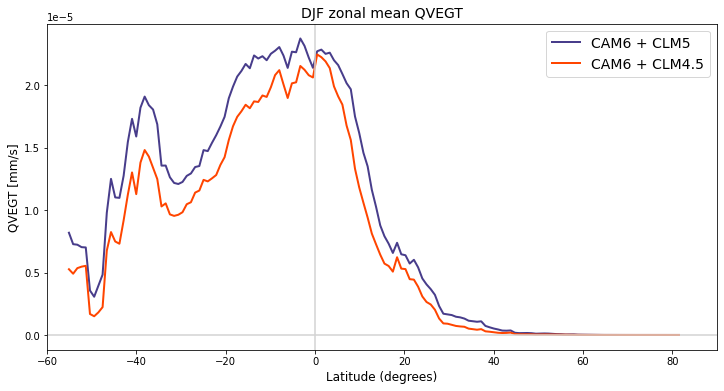

In [83]:
# ------------------------------
#  Plot zonal mean QVEGT [DJF]
# ------------------------------

# Set up figure 
fig, ax1 = plt.subplots(1,1, figsize=(12, 6))

ax1.plot(lat,clm5_ETdf_DJFzonal.QVEGT.values,'darkslateblue', linewidth=2)
ax1.plot(lat,clm45_ETdf_DJFzonal.QVEGT.values,'orangered', linewidth=2)

ax1.legend(['CAM6 + CLM5','CAM6 + CLM4.5'], fontsize=14)
ax1.set_xlabel('Latitude (degrees)',fontsize=12)
ax1.set_ylabel('QVEGT [mm/s]',fontsize=12)
ax1.set_title('DJF zonal mean QVEGT', fontsize=14)
ax1.set_xlim([-60, 90])
ax1.axhline(0,color='lightgrey')
ax1.axvline(0,color='lightgrey')
